<a href="https://colab.research.google.com/github/mtareqsoliman/msthesis/blob/main/Benchmark_RS_DBLANN_12092022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-generic-recommended is already the newest version (2017.20180305-1).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [11]:
!apt-get install texlive dvipng texlive-latex-extra texlive-fonts-recommended


Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-latex-extra set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  ghostscript-x
The following NEW packages will be installed:
  dvipng ghostscript gsfonts texlive
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 3,264 kB of archives.
After this operation, 5,018 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 ghostscript amd64 9.26~dfsg+0-0ubuntu0.18.04.17 [51.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 dvipng amd64 1.15-1 [78.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 gsfonts all 1:8.11+u

In [2]:
!apt-get install texlive-latex-recommended 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


# **1. BENCHMARK**



In [3]:
import pandas as pd
import numpy as np
import math as math
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.gridspec import GridSpec
import scipy.stats as sp
from scipy.optimize import minimize, LinearConstraint
import scipy.optimize as spo
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline

np.seterr(divide='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:

#NLTHA100 = pd.read_excel('https://github.com/mtareqsoliman/msthesis/blob/main/Results/100NLTHA_FINAL.xlsx?raw=true')
NLTHA100 = pd.read_excel('https://github.com/mtareqsoliman/msthesis/blob/main/Results/NLTHA200_v2.xlsx?raw=true')
                          # ln(x)                                mean(ln(x))                                  stdev(ln(x))
from sklearn.preprocessing import StandardScaler
ecu_9600_alpha = StandardScaler().fit_transform(np.log(-NLTHA100[['ecu']]))
Vult_9600_alpha = StandardScaler().fit_transform(np.log(NLTHA100[['Vult']]))

print(ecu_9600_alpha.mean())
print(ecu_9600_alpha.std())

#ecu_9600_alpha = norm.cdf(np.log(-np.array(NLTHA100[['ecu']])), np.log(-np.array(NLTHA100[['ecu']])).mean(), np.log(-np.array(NLTHA100[['ecu']])).std())
#Vult_9600_alpha = norm.cdf(np.log(np.array(NLTHA100[['Vult']])), np.log(np.array(NLTHA100[['Vult']])).mean(),  np.log(np.array(NLTHA100[['Vult']])).std())

#ecu_9600_alpha, Vult_9600_alpha = norm.ppf(ecu_9600_alpha,0,1) , norm.ppf(Vult_9600_alpha,0,1)

NLTHA100.insert(2,'ecu_alpha',ecu_9600_alpha)
NLTHA100.insert(3,'Vult_alpha',Vult_9600_alpha)

del ecu_9600_alpha, Vult_9600_alpha

NLTHA100.head()

-3.091508530654134e-15
1.0


,state,IM,ecu_alpha,Vult_alpha,record,ecu,Vult,Vbmax,ect,ecb,uindex,convergence,SHEAR,STRAIN
0,1,40,-0.570610,0.456099,RSN126_GAZLI_GAZ000,-0.004896,191.600998,147.134665,-0.062174,-0.125112,952,0,0,1
1,1,40,-0.207254,-0.422532,RSN126_GAZLI_GAZ000,-0.005531,161.255244,148.807761,-0.050291,-0.120897,954,0,0,1
2,1,40,0.413132,-2.043077,RSN126_GAZLI_GAZ000,-0.006813,117.327000,154.360952,-0.006356,-0.115730,854,0,1,1
3,1,40,-0.154089,0.033785,RSN126_GAZLI_GAZ000,-0.005631,176.361933,149.708223,-0.050018,-0.120791,954,0,0,1
4,1,40,-0.121856,0.734440,RSN126_GAZLI_GAZ000,-0.005692,202.357926,149.662815,-0.005678,-0.115480,955,1,0,1


In [5]:
NLTHA100_pivot = pd.pivot_table(NLTHA100, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA100_pivot.insert(0,0,0)

NLTHA100_pivot

,IM,0,5,10,15,20,25,30,35,40
ecu_alpha,Vult_alpha,,,,,,,,,
-2.260427,-0.038354,0,0,4,8,10,12,12,12,12
-2.256878,-0.077853,0,0,4,8,10,12,12,12,12
-2.206836,0.577809,0,0,4,8,10,12,12,12,12
-2.152496,-0.743485,0,0,3,8,10,12,12,12,12
-2.142272,-0.694130,0,0,4,8,10,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...
2.053824,0.723751,0,0,0,0,0,2,7,8,10
2.111884,1.605870,0,0,0,0,0,2,5,8,10
2.128592,1.187527,0,0,0,0,0,2,5,8,10


In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

ecu_100_alpha_frag, Vult_100_alpha_frag = zip(*NLTHA100_pivot.index.values)
ecu_100_alpha_frag, Vult_100_alpha_frag = np.asarray(ecu_100_alpha_frag), np.asarray(Vult_100_alpha_frag)

lambda_100_list = []
zeta_100_list = []
z_100_list = []

IM = np.arange(0,45,5)
fragility_table_100 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_NLTHA100_i,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_100_alpha_frag):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_NLTHA100_i = NLTHA100_pivot.iloc[i]
    nrcrds = 12

    # starting guess
    lambdazeta_start = [24,0.4]

    # Bounds
    bnds = ((4, 50), (0.2, 1))
    
    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_100_list.append(lambda_mxlk)
        zeta_100_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_100_list.append(z_mxlk)
        fragility_table_100.loc[i] = sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)

    else:
        print("Failed!", end = '\n')
        break

fragility_table_100

,0,5,10,15,20,25,30,35,40
0,0.0,6.838647e-03,2.768389e-01,0.692726,0.899923,0.970231,0.991272,0.997394,0.999196
1,0.0,6.838647e-03,2.768389e-01,0.692726,0.899923,0.970231,0.991272,0.997394,0.999196
2,0.0,6.838647e-03,2.768389e-01,0.692726,0.899923,0.970231,0.991272,0.997394,0.999196
3,0.0,2.527306e-03,2.221761e-01,0.665558,0.898634,0.973203,0.993175,0.998248,0.999538
4,0.0,6.838647e-03,2.768389e-01,0.692726,0.899923,0.970231,0.991272,0.997394,0.999196
...,...,...,...,...,...,...,...,...,...
195,0.0,1.159292e-15,4.569850e-07,0.000826,0.029005,0.177369,0.447201,0.704534,0.868228
196,0.0,2.114654e-17,7.373477e-08,0.000322,0.017645,0.137695,0.396661,0.669555,0.852138
197,0.0,2.114654e-17,7.373477e-08,0.000322,0.017645,0.137695,0.396661,0.669555,0.852138
198,0.0,1.696356e-22,2.450944e-10,0.000014,0.002921,0.050424,0.232954,0.516592,0.760918


In [7]:
def frag(lambdazeta):
  estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
  log_likelihood = sp.binom.pmf(ncllps_bmark,nrcrds,estimated_fragility)
  fun = -np.sum(log_likelihood)

  return fun
factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_bmark = np.median(NLTHA100_pivot,axis=0)
#pcllps =  ncllps_bmark/nrcrds

# starting guess
lambdazeta_start = [24,0.4]

# Bounds
bnds = ((4, 50), (0.2, 5))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

if result.success:
    print("Success!", end = '\n')
    miny = result.x
    lambda_mxlk_bmark = round(miny[0],2)
    zeta_mxlk_bmark = round(miny[1],2)
    z_mxlk_bmark = -round(result.fun,2)

NLTHA100_lz = [lambda_mxlk_bmark,zeta_mxlk_bmark,z_mxlk_bmark]
NLTHA100_frag = sp.norm.cdf(np.log(np.linspace(0,40,100)),np.log(NLTHA100_lz[0]),NLTHA100_lz[1])

Success!


Now we will draw the histogram for IM=20cm/sec

In [8]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [9]:
pip install tikzplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


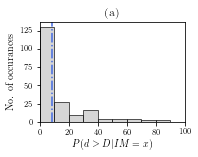

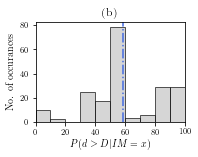

In [58]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib as pltuse
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import tikzplotlib

fmt = '%.0f%%' 
pticks = mtick.FormatStrFormatter(fmt)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.autolayout": True
})

width = 412.56496
width = 413

#fig.tight_layout(pad=4.0)
for y,sel_IM,title in zip([0,1],[10,20],['(a)','(b)']):
  fig, ax = plt.subplots(figsize=(width*0.5/72.27,width*0.4/72.27))

  ax.hist(NLTHA100_pivot[sel_IM]*100/12,color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min(NLTHA100_pivot[sel_IM]*100/12), max(NLTHA100_pivot[sel_IM]*100/12) + 10, 10))
  ax.set_xlim(0,100)
  ax.set_ylim(0)
  ax.set_title(title)
  ax.xaxis.set_major_formatter(pticks)
  ax.set_xlabel(r'$P(d>D|IM=x)$')
  ax.set_ylabel('No. of occurances')   
  #ax.set_title('Histogram for PGV='+str(sel_IM)+' cm/s')  
  ax.axvline(np.median(NLTHA100_pivot[sel_IM]*100/12,axis=0),color='royalblue', linestyle='-.', linewidth=1.5)
  #ax2 = ax[1,0].twinx()  # instantiate a second axes that shares the same x-axis
  #ax2.tick_params(axis='y')
  #ax2.violinplot(NLTHA100_pivot[sel_IM]/12,positions=[sel_IM],widths=5.5)
  plt.savefig('histogram1020_benchmark_'+str(sel_IM)+'.pgf', backend='pgf', dpi=600, bbox_inches="tight", transparent=True)
  #plt.savefig('histogram1020_benchmark_'+str(sel_IM)+'.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)
  #tikzplotlib.save("histogram1020_benchmark_"+str(sel_IM)+".tex")



IM
10    0.083333
dtype: float64

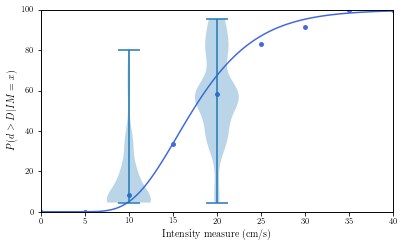

In [59]:
fig, ax = plt.subplots(figsize=set_size(width))
#fig.tight_layout(pad=4.0)

ax.set_xlim(0,40)
ax.set_ylim(0,100)
ax.yaxis.set_major_formatter(pticks)
ax.plot(np.linspace(0,40,100),NLTHA100_frag*100,linestyle='-',color='royalblue')
ax.scatter(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0)*100/12,s=15,color='royalblue')
ax.set_xlabel('Intensity measure (cm/s)')
ax.set_ylabel(r'$P(d>D|IM=x)$')
#ax.set_title('Benchmark collapse fragility with violinplots superimposed')

        # 100 points of x,    interpolation for the curve,                                                              clearing non-zeroes

#do not forget to make the straight line between 0 and 5

ax3 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks([])
ax3.violinplot(np.array(NLTHA100_pivot[[10,20]]),positions=[10,20],widths=5)
plt.savefig('finalfrag_bmark.pgf', backend='pgf', dpi=600, bbox_inches="tight", transparent=True)
#plt.savefig('finalfrag_bmark.pdf', backend='pdf', dpi=600, bbox_inches="tight", transparent=True)
NLTHA100_pivot[[10]].median()/12

In [29]:
NLTHA100_pivot_2 = pd.pivot_table(NLTHA100, values='state', index=['ecu','Vult'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA100_pivot_2.insert(0,0,0)
ecu_100, Vult_100 = zip(*NLTHA100_pivot_2.index.values)
NLTHA100_pivot

,IM,0,5,10,15,20,25,30,35,40
ecu_alpha,Vult_alpha,,,,,,,,,
-2.260427,-0.038354,0,0,4,8,10,12,12,12,12
-2.256878,-0.077853,0,0,4,8,10,12,12,12,12
-2.206836,0.577809,0,0,4,8,10,12,12,12,12
-2.152496,-0.743485,0,0,3,8,10,12,12,12,12
-2.142272,-0.694130,0,0,4,8,10,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...
2.053824,0.723751,0,0,0,0,0,2,7,8,10
2.111884,1.605870,0,0,0,0,0,2,5,8,10
2.128592,1.187527,0,0,0,0,0,2,5,8,10


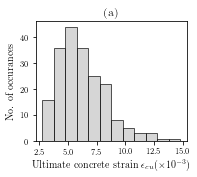

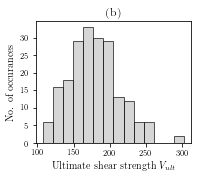

In [78]:
fig, ax = plt.subplots(figsize=(width*0.5/72.27,width*0.45/72.27))
ax.set_title('(a)')
ax.hist(-np.asarray(ecu_100)*1000,color='silver', edgecolor='k', alpha=0.65, bins=np.arange(min(-np.asarray(ecu_100)*1000), max(-np.asarray(ecu_100)*1000) + 1, 1))
ax.set_xlabel(r'Ultimate concrete strain $\epsilon _{cu}  (\times 10^{-3})$')
ax.set_ylabel('No. of occurances')   
plt.savefig('histogram_criteria_e.pgf', backend='pgf', dpi=600, bbox_inches="tight", transparent=True)

fig, ax = plt.subplots(figsize=(width*0.5/72.27,width*0.45/72.27))
ax.set_title('(b)')
ax.hist(np.asarray(Vult_100),color='silver', edgecolor='k', alpha=0.65, bins=np.arange(min(np.asarray(Vult_100)), max(np.asarray(Vult_100)) + 14, 14))
ax.set_xlabel(r'Ultimate shear strength $V_{ult}$')
ax.set_ylabel('No. of occurances')   
plt.savefig('histogram_criteria_V.pgf', backend='pgf', dpi=600, bbox_inches="tight", transparent=True)



# **2. RESPONSE SURFACE**

In [ ]:
NLTHA9 = pd.read_excel('https://github.com/mtareqsoliman/msthesis/blob/main/Results/9NLTHA_FINAL.xlsx?raw=true',index_col=0)
NLTHA9

In [ ]:
NLTHA9_pivot = pd.pivot_table(NLTHA9, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA9_pivot.insert(0,0,0)

NLTHA9_pivot

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

ecu_9_alpha_frag, Vult_9_alpha_frag = zip(*NLTHA9_pivot.index.values)
ecu_9_alpha_frag, Vult_9_alpha_frag = np.asarray(ecu_9_alpha_frag), np.asarray(Vult_9_alpha_frag)

lambda_9_list = []
zeta_9_list = []
z_9_list = []

IM = np.arange(0,45,5)
fragility_table_9CCM = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_CCM9_i,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_9_alpha_frag[0:9]):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_CCM9_i = NLTHA9_pivot.iloc[i]
    nrcrds = 12

    # starting guess
    lambdazeta_start = [24,0.4]

    # Bounds
    bnds = ((4, 50), (0.2, 1))
    
    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        print("Success!", end = '\n')
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_9_list.append(lambda_mxlk)
        zeta_9_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_9_list.append(z_mxlk)

    else:
        print("Failed!", end = '\n')
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_9_list.append(lambda_mxlk)
        zeta_9_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_9_list.append(z_mxlk)
        #fragility_table_9CCM.loc[i] = np.ceil(sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)*12)


In [ ]:
from sklearn.preprocessing import StandardScaler
 

x1_CCM9,x2_CCM9 = map(list,zip(*NLTHA9_pivot.index.values))

x_CCM9 =np.column_stack((x1_CCM9,x2_CCM9))
y_CCM9 = np.column_stack((np.log(lambda_9_list),zeta_9_list))

################ 2nd degree
deg2_polymodel = PolynomialFeatures(degree=2)
x_poly_CCM9_deg2 = deg2_polymodel.fit_transform(x_CCM9)

# should be in the form [1, a, b, a^2, ab, b^2]
deg2_polymodel.fit(x_poly_CCM9_deg2, y_CCM9)
deg2_CCM9_regmodel = LinearRegression()
deg2_CCM9_regmodel.fit(x_poly_CCM9_deg2, y_CCM9)

y_pred_deg2 = deg2_CCM9_regmodel.predict(x_poly_CCM9_deg2)
print(deg2_CCM9_regmodel.coef_)
#p00,p10,p01,p20,p11,p02 = deg2_CCM9_regmodel.coef_.T
MSE = mean_squared_error(y_CCM9, y_pred_deg2, squared=False)

x1_mesh,x2_mesh = np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)
x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh)
x_mesh = np.array([x1_mesh.flatten(), x2_mesh.flatten()]).T
poly_x_mesh = deg2_polymodel.fit_transform(x_mesh)
y_mesh_deg2 = deg2_CCM9_regmodel.predict(poly_x_mesh)

################ 3rd degree 
deg3_polymodel = PolynomialFeatures(degree=3)
x_poly_CCM9_deg3 = deg3_polymodel.fit_transform(x_CCM9)

# should be in the form []
deg3_polymodel.fit(x_poly_CCM9_deg3, y_CCM9)
deg3_CCM9_regmodel = LinearRegression()
deg3_CCM9_regmodel.fit(x_poly_CCM9_deg3, y_CCM9)
y_pred_deg3 = deg3_CCM9_regmodel.predict(x_poly_CCM9_deg3)
print(deg3_CCM9_regmodel.coef_)
#p00,p10,p01,p20,p11,p02 = deg3_CCM9_regmodel.coef_.T
MSE = mean_squared_error(y_CCM9, y_pred_deg3, squared=False)

x1_mesh,x2_mesh = np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)
x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh)
x_mesh = np.array([x1_mesh.flatten(), x2_mesh.flatten()]).T
poly_x_mesh = deg3_polymodel.fit_transform(x_mesh)
y_mesh_deg3 = deg3_CCM9_regmodel.predict(poly_x_mesh)


fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16,labelpad=10)
ax.set_ylabel(r"$\alpha_v$",fontsize=16,labelpad=10)
ax.set_title(r"Response surface: logarithmic mean $\lambda$",fontsize=16)
fig.tight_layout(pad=5.0)


ax.scatter(x_CCM9[:,0], x_CCM9[:,1], np.exp(y_CCM9[:,0]),color='black',marker='.',alpha=1,s=70)
ax.scatter(x1_mesh, x2_mesh, np.exp(y_mesh_deg2[:,0]), facecolor=(0,0,0,0), s=20, edgecolor='gray')

plt.savefig('RSM_surf_lambda.pgf', backend='pgf')


fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})


ax.set_zlabel(r"$\zeta$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16,labelpad=10)
ax.set_ylabel(r"$\alpha_v$",fontsize=16,labelpad=10)
ax.set_title(r"Response surface: std. deviation $\zeta$",fontsize=16)
fig.tight_layout(pad=5.0)

ax.scatter(x_CCM9[:,0], x_CCM9[:,1], y_CCM9[:,1],color='black',marker='.',alpha=1,s=70)
ax.scatter(x1_mesh, x2_mesh, y_mesh_deg2[:,1], facecolor=(0,0,0,0), s=20, edgecolor='gray')
plt.savefig('RSM_surf_zeta.pgf', backend='pgf')

# should be in the form [1, a, b, a^2, ab, b^2]

In [ ]:
alpha_ecu_1000 = np.random.normal(0, 1, 1000)
alpha_Vult_1000 = np.random.normal(0, 1, 1000)

x_1000_CCM9 = np.array([alpha_ecu_1000, alpha_Vult_1000]).T
x_1000_poly_CCM9_deg2 = deg2_polymodel.fit_transform(x_1000_CCM9)
y_1000_CCM9_deg2 = deg2_CCM9_regmodel.predict(x_1000_poly_CCM9_deg2)
x_1000_poly_CCM9_deg3 = deg3_polymodel.fit_transform(x_1000_CCM9)
y_1000_CCM9_deg3 = deg3_CCM9_regmodel.predict(x_1000_poly_CCM9_deg3)


fragility_table_CCM9_1000_deg2 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
fragility_table_CCM9_1000_deg3 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_1000_CCM9_deg2)):
  fragility_table_CCM9_1000_deg2.loc[i] = sp.norm.cdf(np.log(IM),y_1000_CCM9_deg2[i,0],y_1000_CCM9_deg2[i,1])*12
for i in np.arange(len(y_1000_CCM9_deg3)):
  fragility_table_CCM9_1000_deg3.loc[i] = sp.norm.cdf(np.log(IM),y_1000_CCM9_deg3[i,0],y_1000_CCM9_deg3[i,1])*12


fragility_table_CCM9_1000_deg3

In [ ]:
np.round(fragility_table_CCM9_1000_deg2.median())

In [ ]:
np.round(fragility_table_CCM9_1000_deg3.median())

In [ ]:
import math
def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_CCM1000_deg2,12,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_CCM1000_deg2 = np.round(fragility_table_CCM9_1000_deg2.median())
pcllps_CCM1000_deg2 = ncllps_CCM1000_deg2/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((4, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
CCM9_1000_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    CCM9_1000_lambda = round(miny[0],2)
    CCM9_1000_zeta = round(miny[1],2)
    CCM9_1000_cost = -round(result.fun,2)

CCM9_1000_lz_deg2 = [CCM9_1000_lambda,CCM9_1000_zeta,CCM9_1000_cost]
CCM9_1000_lgnrml_deg2 = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(CCM9_1000_lz_deg2[0]),CCM9_1000_lz_deg2[1])

print(result)

In [ ]:
import math
def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_CCM1000_deg3,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_CCM1000_deg3 = np.round(fragility_table_CCM9_1000_deg3.median())
pcllps_CCM1000_deg3 = ncllps_CCM1000_deg3/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((4, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
CCM9_1000_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    CCM9_1000_lambda_deg3 = round(miny[0],2)
    CCM9_1000_zeta_deg3 = round(miny[1],2)
    CCM9_1000_cost_deg3 = -round(result.fun,2)

CCM9_1000_lz_deg3 = [CCM9_1000_lambda_deg3,CCM9_1000_zeta_deg3,CCM9_1000_cost_deg3]
CCM9_1000_lgnrml_deg3 = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(CCM9_1000_lz_deg3[0]),CCM9_1000_lz_deg3[1])

print(result)

In [ ]:
##from scipy.interpolate import interp1d
import matplotlib.ticker as mtick

#CCM9_1000_lz = fit_lognormal(np.median(fragility_table_CCM9_1000_deg2,axis=0))
#CCM9_1000_lgnrml = sp.norm.cdf(np.log(np.linspace(0,40,100)),np.log(CCM9_1000_lz[0]),CCM9_1000_lz[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize =(18,5))

for y,sel_IM in zip([0,1],["10","20"]):
  ax[y].hist((fragility_table_CCM9_1000_deg2[sel_IM])/12,color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min((fragility_table_CCM9_1000_deg2[sel_IM])/12), max((fragility_table_CCM9_1000_deg2[sel_IM])/12) + 0.1, 0.1))
  ax[y].set_xlim(0,1)
  ax[y].set_ylim(0)
  ax[y].set_xlabel('P(D>d|IM=x)')
  #ax[y].set_xticks([np.linspace(0,1.1,0.1)])
  ax[y].set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax[y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec (RSM)') ### Title is not ready
  ax[y].axvline(fragility_table_CCM9_1000_deg2[sel_IM].median()/12, color='crimson', linestyle='-.', linewidth=3)

        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes

fig, ax = plt.subplots(nrows=1,ncols=1,figsize =(18,10))

##ax.plot(np.linspace(5,40,1000),make_interp_spline(np.arange(0,45,5),fragility_table_CCM9_1000_deg2.median())(np.linspace(5,40,1000)).clip(0)*100/12,linestyle='-',color='crimson',label='Response surface method (2nd degree)',linewidth=1)
##ax.plot(np.linspace(5,40,1000),make_interp_spline(np.arange(0,45,5),fragility_table_CCM9_1000_deg3.median())(np.linspace(5,40,1000)).clip(0)*100/12,linestyle='-',color='green',label='Response surface method (3rd degree)',linewidth=1)

ax.plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg2*100,linestyle='-',color='crimson',label='Response surface method (2nd degree)', linewidth=1)
ax.plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg3*100,linestyle='-',color='maroon',label='Response surface method (3rd degree)', linewidth=1)

#ax.plot(np.linspace(5,40,100),NLTHACCM9_frag,linestyle='--',color='red')
ax.scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000_deg2,axis=0)*100/12,s=15,color='crimson')
ax.scatter(np.arange(0,45,5),fragility_table_CCM9_1000_deg3.median()*100/12,s=15,color='maroon')

ax.plot(np.linspace(0,40,100),NLTHA100_frag*100,linestyle='-',color='royalblue',label='Benchmark',linewidth=2)
ax.scatter(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0)*100/12,s=15,color='royalblue')

ax.set_xlim(0,40)
ax.set_ylim(0,100)
ax.set_title('Final collapse fragility curves')
ax.set_xlabel('Intensity measure (cm/sec)')
ax.set_ylabel('P(d>D|IM=x)')
ax.legend()

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_CCM9_1000_deg2.median()/12

# **3. Artifical neural network (trained to *predict* λ and ζ)**

In [ ]:
NLTHA100

In [ ]:
NLTHA100_pivot

In [ ]:
##pivot_numpy = np.concatenate((np.zeros(9)[:, np.newaxis], pivot_numpy), axis=1)
ecu_100_alpha, Vult_100_alpha = zip(*NLTHA100_pivot.index.values)
ecu_100_alpha, Vult_100_alpha = np.asarray(ecu_100_alpha), np.asarray(Vult_100_alpha)

result_100_list,lambda_100_list,zeta_100_list = [],[],[]

IM = np.arange(0,45,5)
fragility_table_100 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(pcllps*nrcrds,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_100_alpha):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_NLTHA100 = NLTHA100_pivot.iloc[i]
    nrcrds = 12
    pcllps = ncllps_NLTHA100/nrcrds
    # starting guess
    lambdazeta_start = [24,0.4] 
    # Bounds
    bnds = ((4, 50), (0.2, 1))


    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_100_list.append(lambda_mxlk)
        zeta_100_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_list.append(z_mxlk)
        fragility_table_100.loc[i] = sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)

lambda_100_list = np.array(lambda_100_list)
zeta_100_list = np.array(zeta_100_list)

print(pd.DataFrame({"eps":ecu_100_alpha,"V":Vult_100_alpha,"$lambda$":lambda_100_list,'$zeta$':zeta_100_list,'cost':z_list},index=None))

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.scatter(ecu_100_alpha, Vult_100_alpha, lambda_100_list)
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Computed $\lambda$ property for 100 NLTH simulations",fontsize=16)

fig.show()
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(ecu_100_alpha, Vult_100_alpha, zeta_100_list)
ax.set_zlabel(r"$\zeta$",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Computed $\zeta$ property for 100 NLTH simulations",fontsize=16)

fig.show()

In [ ]:
from sklearn.neural_network import MLPRegressor

ecu_100_alpha, Vult_100_alpha = map(list,zip(*NLTHA100_pivot.index.values))
x_ANN =np.column_stack((ecu_100_alpha,Vult_100_alpha))
y_ANN = np.column_stack((lambda_100_list,zeta_100_list))

X_train, X_test, y_train, y_test = train_test_split(x_ANN, y_ANN, train_size=0.5, test_size=0.2)

regr_ANN = MLPRegressor(hidden_layer_sizes=(9,3),solver='lbfgs', alpha=0.5)
regr_ANN.fit(X_train, y_train)

y_pred_train_m1 = regr_ANN.predict(X_train)
y_pred_test_m1 = regr_ANN.predict(X_test)
y_pred_ANN = regr_ANN.predict(x_ANN)
MSE = mean_squared_error(y_test, y_pred_test_m1, squared=False)
print(MSE)


x1_mesh_ANN,x2_mesh_ANN = np.linspace(-2.5, 2.5, 50), np.linspace(-2.5, 2.5, 50)
x1_mesh_ANN, x2_mesh_ANN = np.meshgrid(x1_mesh_ANN, x2_mesh_ANN)
X_mesh_ANN = np.array([x1_mesh_ANN.flatten(), x2_mesh_ANN.flatten()]).T
y_mesh_ANN = regr_ANN.predict(X_mesh_ANN)

fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"$\lambda$ property obtained from ANN with 9 perceptrons and 3 layers",fontsize=16)
ax.scatter(x_ANN[:,0], x_ANN[:,1], y_ANN[:,0],color='black',marker='.',alpha=1,s=40)
ax.scatter(x1_mesh_ANN, x2_mesh_ANN, y_mesh_ANN[:,0], facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')

fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\zeta$",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"$\zeta$ property obtained from ANN with 9 perceptrons and 3 layers",fontsize=16)
ax.scatter(x_ANN[:,0], x_ANN[:,1], y_ANN[:,1],color='black',marker='.',alpha=1,s=40)
ax.scatter(x1_mesh_ANN, x2_mesh_ANN, y_mesh_ANN[:,1], facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')

result_table = pd.DataFrame({'y_act':y_ANN.tolist(),'y_pred':y_pred_ANN.tolist()}).to_excel('ssss.xlsx')

IM = np.arange(0,45,5)
fragility_table_ANN = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

for i in np.arange(len(y_ANN)):
  fragility_table_ANN.loc[i] = sp.norm.cdf(np.log(IM),np.log(y_ANN[i,0]),y_ANN[i,1])
fragility_table_ANN


1000 realization for ANN

In [ ]:
alpha_ecu_1000 = np.random.normal(0, 1, 1000)
alpha_Vult_1000 = np.random.normal(0, 1, 1000)

x_1000_ANN = np.array([alpha_ecu_1000, alpha_Vult_1000]).T
y_1000_ANN = regr_ANN.predict(x_1000_ANN)

fragility_table_ANN_1000 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_1000_ANN)):
  fragility_table_ANN_1000.loc[i] = sp.norm.cdf(np.log(IM),np.log(y_1000_ANN[i,0]),y_1000_ANN[i,1])
fragility_table_ANN_1000

In [ ]:
ecu_100_alpha_frag, Vult_100_alpha_frag = zip(*NLTHA100_pivot.index.values)

x_100 = np.array([ecu_100_alpha_frag, Vult_100_alpha_frag]).T
y_100_ANN = regr_ANN.predict(x_100)

fragility_table_ANN_100 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_100_ANN)):
  fragility_table_ANN_100.loc[i] = sp.norm.cdf(np.log(IM),np.log(y_100_ANN[i,0]),y_100_ANN[i,1])

x_100_poly_CCM9_deg2 = deg2_polymodel.fit_transform(x_100)
y_100_CCM9_deg2 = deg2_CCM9_regmodel.predict(x_100_poly_CCM9_deg2)

fragility_table_CCM9_100_deg2 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_100_ANN)):
  fragility_table_CCM9_100_deg2.loc[i] = sp.norm.cdf(np.log(IM),np.log(y_100_CCM9_deg2[i,0]),y_100_CCM9_deg2[i,1])

In [ ]:

MSE = mean_squared_error(fragility_table_100, fragility_table_ANN_100, squared=False)
r2 = r2_score(fragility_table_100, fragility_table_ANN_100)

y_ANN_residual = (fragility_table_100-fragility_table_ANN_100)
y_CCM9_deg2_residual = (fragility_table_100-fragility_table_CCM9_100_deg2)
y_CCM9_deg3_residual = (fragility_table_100-fragility_table_CCM9_100_deg3)

y_CCM9_deg2_residual

In [ ]:
fragility_table_ANN_1000.median()*12

In [ ]:

import math
def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_ANN1000,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_ANN1000 = np.round(fragility_table_ANN_1000.median()*12)
pcllps_ANN1000 = ncllps_ANN1000/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((4, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
ANN1000_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    ANN1000_lambda = round(miny[0],2)
    ANN1000_zeta = round(miny[1],2)
    ANN1000_cost = -round(result.fun,2)

ANN1000_lz = [ANN1000_lambda,ANN1000_zeta,ANN1000_cost]
ANN1000_lgnrml = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(ANN1000_lz[0]),ANN1000_lz[1])

print(result)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize =(18,10))

for lbl,clr,rsdl,mrkr in zip(['Response surface method (2nd degree)','Response surface method (3rd degree)'],['green','red'],[y_CCM9_deg2_residual,y_CCM9_deg3_residual],['^','^']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax.scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title(r"Relative error for P(D>d|IM=x)")
    ax.set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax.set_xlabel(r"Intensity measure (cm/sec)")

    ax.legend(loc='best', fancybox=True, framealpha=1)

    print('\n')
# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_ANN_1000.median()

In [ ]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(nrows=2,ncols=2,figsize =(18,10))
for y,sel_IM in zip([0,1],["10","20"]):
  ax[0,y].hist(fragility_table_ANN_1000[sel_IM],color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min(fragility_table_ANN_1000[sel_IM]), max(fragility_table_ANN_1000[sel_IM]) + 0.1, 0.1))
  ax[0,y].set_xlim(0,1)
  ax[0,y].set_ylim(0)
  ax[0,y].set_xlabel('P(D>d|IM=x)')
  #ax[0,y].set_xticks([np.linspace(0,1.1,0.1)])
  ax[0,y].set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax[0,y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec') ### Title is not ready
  ax[0,y].axvline(np.median(fragility_table_ANN_1000[sel_IM],axis=0), color='gray', linestyle='dashed', linewidth=3)


        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes
ax[1,0].plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg2*100,linestyle='-',color='crimson',label='Response surface method (2nd degree)')
#ax[1,0].plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg3*1,linestyle='-',color='green',label='Response surface method (3rd degree)')

ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000_deg2,axis=0)*100/12,s=15,color='crimson')
#ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000_deg3.median()*1/12,s=15,color='green')

ax[1,0].plot(np.linspace(0,40,100),NLTHA100_frag*100,linestyle='-',color='royalblue',label='Montecarlo Simulation ')
ax[1,0].scatter(np.arange(0,45,5),NLTHA100_pivot.median()*100/12,s=15,color='royalblue')
#ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_ANN_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),dashes=[4, 4],color='green',label='ANN algorithm')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_ANN_1000.median()*100,s=15,color='green')

ax[1,0].plot(np.linspace(0,40,1000),ANN1000_lgnrml*100,linestyle='--',color='green',label='ANN algorithm')

#ANN1000_lgnrml

ax[1,0].legend()

'''
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),np.median(fragility_table_ANN_1000.iloc[:,1:],axis=0))(np.linspace(5,40,1000)).clip(0),linestyle='--')
ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_ANN_1000,axis=0),s=15)
ax[1,0].plot(np.linspace(0,40,1000),make_interp_spline(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0))(np.linspace(0,40,1000)).clip(0),linestyle='-')
ax[1,0].scatter(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0),s=15)
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),np.median(fragility_table_CCM9_1000.iloc[:,1:],axis=0))(np.linspace(5,40,1000)).clip(0),linestyle='--')
ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000,axis=0),s=15)
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_CCM9_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),linestyle='-',color='crimson',label='Central composite method')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000.median(),s=15,color='crimson')
'''

ax[1,0].set_xlim(0,40)
ax[1,0].set_ylim(0,100)
ax[1,0].set_title('Medians of collapse fragilities')
ax[1,0].set_xlabel('Intensity measure (cm/sec)')
ax[1,0].set_ylabel('P(d>D|IM=x)')
ax[1,0].legend()

######## testing phase ################

## preparing data

for lbl,clr,rsdl,mrkr in zip(['Central composite method (2nd degree)','ANN algorithm'],['red','green'],[y_CCM9_deg2_residual,y_ANN_residual],['^','^']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax[1,1].scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax[1,1].scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax[1,1].scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax[1,1].spines['bottom'].set_position('zero')
    ax[1,1].spines['right'].set_color('none')
    ax[1,1].spines['top'].set_color('none')
    ax[1,1].set_title(r"Relative error for P(D>d|IM=x)")
    ax[1,1].set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax[1,1].set_xlabel(r"Intensity measure (cm/sec)")

    ax[1,1].legend(loc='best', fancybox=True, framealpha=1)

    print('\n')
# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_ANN_1000.median()

In [ ]:
for i in np.arange(0,100,1):
    print(y_ANN_residual.iloc[i])

In [ ]:
######## testing phase ################

## preparing data

fig,ax = plt.subplots(figsize=(18,10))
for lbl,clr,rsdl,mrkr in zip(['Central composite method','ANN'],['red','green'],[y_CCM9_residual,y_ANN_residual],['^','^']):
    for i in np.arange(0,100,1):
        if i == 0:
          ax.scatter([ecu_100_alpha_frag[i]]*9,rsdl.iloc[i],color=clr,s=15,label=lbl,alpha=0.3,marker=mrkr)
        else:
          ax.scatter([ecu_100_alpha_frag[i]]*9,rsdl.iloc[i],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax.scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title(r"Relative error for P(D>d|IM=x)")
    ax.set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax.set_xlabel(r"$\alpha_{ecu}$")

    ax.legend()

    print('\n')

In [ ]:
fig,ax = plt.subplots(figsize=(18,10))
for lbl,clr,rsdl,mrkr in zip(['Central composite method','ANN algorithm'],['red','green'],[y_CCM9_residual,y_ANN_residual],['^','^']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax.scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title(r"Relative error for P(D>d|IM=x)")
    ax.set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax.set_xlabel(r"Intensity measure (cm/sec)")

    ax.legend()

    print('\n')

# **ANN** Method 2

In [ ]:
from sklearn.neural_network import MLPRegressor

ecu_100_alpha, Vult_100_alpha = map(list,zip(*NLTHA100_pivot.index.values))
x_ANN2 =np.column_stack((ecu_9_alpha_frag,Vult_9_alpha_frag))
y_ANN2 = NLTHA9_pivot.values

regr_ANN2 = MLPRegressor(alpha=0.32)
regr_ANN2.fit(x_ANN2, y_ANN2)

y_pred_ANN2 = regr_ANN2.predict(x_ANN2)
MSE = mean_squared_error(y_ANN2, y_pred_ANN2, squared=False)
print(MSE)

x1_mesh_ANN,x2_mesh_ANN = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1_mesh_ANN, x2_mesh_ANN = np.meshgrid(x1_mesh_ANN, x2_mesh_ANN)
X_mesh_ANN = np.array([x1_mesh_ANN.flatten(), x2_mesh_ANN.flatten()]).T
y_mesh_ANN2 = regr_ANN2.predict(X_mesh_ANN)

IM = np.arange(0,45,5)
fragility_table_ANN2 = pd.DataFrame(y_pred_ANN2,columns = ['0','5','10','15','20','25','30','35','40'])
fragility_table_ANN2

In [ ]:

alpha_ecu_1000 = np.random.normal(0, 1, 1000)
alpha_Vult_1000 = np.random.normal(0, 1, 1000)

x_1000_ANN = np.array([alpha_ecu_1000, alpha_Vult_1000]).T
y_1000_ANN2 = regr_ANN2.predict(x_1000_ANN)

fragility_table_ANN2_1000 = pd.DataFrame(y_1000_ANN2,columns = ['0','5','10','15','20','25','30','35','40'])

In [ ]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(nrows=2,ncols=2,figsize =(18,10))
for y,sel_IM in zip([0,1],["10","20"]):
  ax[0,y].hist(fragility_table_ANN2_1000[sel_IM],color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min(fragility_table_ANN2_1000[sel_IM]), max(fragility_table_ANN2_1000[sel_IM]) + 0.1, 0.1))
  ax[0,y].set_xlim(0,1)
  ax[0,y].set_ylim(0)
  ax[0,y].set_xlabel('P(D>d|IM=x)')
  #ax[0,y].set_xticks([np.linspace(0,1.1,0.1)])
  ax[0,y].set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax[0,y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec') ### Title is not ready
  ax[0,y].axvline(np.median(fragility_table_ANN2_1000[sel_IM],axis=0), color='gray', linestyle='dashed', linewidth=3)


        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_CCM9_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),dashes=[6, 2],color='crimson',label='Central composite method')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000.median(),s=15,color='crimson')
ax[1,0].plot(np.linspace(0,40,100),NLTHA100_frag,linestyle='-',color='royalblue',label='Montecarlo Simulation ')
ax[1,0].scatter(np.arange(0,45,5),NLTHA100_pivot.median(),s=15,color='royalblue')
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_ANN2_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),dashes=[4, 4],color='green',label='ANN algorithm')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_ANN2_1000.median(),s=15,color='green')

ax[1,0].legend()

ax[1,0].set_xlim(0,40)
ax[1,0].set_ylim(0,1)
ax[1,0].set_title('Medians of collapse fragilities')
ax[1,0].set_xlabel('Intensity measure (cm/sec)')
ax[1,0].set_ylabel('P(d>D|IM=x)')
ax[1,0].legend()
# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_ANN_1000.median()

In [ ]:
data = np.random.normal(0, 1, 100) 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

ax1.set_title('Default violin plot')
ax1.set_ylabel('Observed values')
ax1.violinplot(data,positions=[2])


In [ ]:
import tensorflow as tf

ann = tf.keras.models.Sequential()
# Add the input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=12, activation='relu', input_shape=X_train.shape))
# Add the second hidden layer
ann.add(tf.keras.layers.Dense(units=8, activation='relu'))
# Add the output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# 4. ANN Second Method 

In [ ]:

NLTHA49mesh = pd.read_excel('https://github.com/mtareqsoliman/msthesis/blob/main/Results/NLTHA49mesh.xlsx?raw=true')
                          # ln(x)                                mean(ln(x))                                  stdev(ln(x))
#ecu_9600_alpha = norm.cdf(np.log(-np.array(NLTHA49mesh[['ecu']])), np.log(-np.array(NLTHA49mesh[['ecu']])).mean(), np.log(-np.array(NLTHA49mesh[['ecu']])).std())
#Vult_9600_alpha = norm.cdf(np.log(np.array(NLTHA49mesh[['Vult']])), np.log(np.array(NLTHA49mesh[['Vult']])).mean(),  np.log(np.array(NLTHA49mesh[['Vult']])).std())

#ecu_9600_alpha, Vult_9600_alpha = norm.ppf(ecu_9600_alpha,0,1) , norm.ppf(Vult_9600_alpha,0,1)

NLTHA49mesh['flex_fail'] = np.greater(NLTHA49mesh['ecu'],np.minimum(NLTHA49mesh['ecb'],NLTHA49mesh['ecb']))
NLTHA49mesh['shear_fail'] = np.greater(NLTHA49mesh['Vbmax'],NLTHA49mesh['Vult'])

NLTHA49mesh.head(10)

In [ ]:
NLTHA49mesh_pivot = pd.pivot_table(NLTHA49mesh, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA49mesh_pivot.insert(0,0,0)

NLTHA49mesh_strain_pivot = pd.pivot_table(NLTHA49mesh, values='flex_fail', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA49mesh_strain_pivot.insert(0,0,0)


NLTHA49mesh_shear_pivot = pd.pivot_table(NLTHA49mesh, values='shear_fail', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA49mesh_shear_pivot.insert(0,0,0)

NLTHA49mesh_strain_pivot

In [ ]:
##pivot_numpy = np.concatenate((np.zeros(9)[:, np.newaxis], pivot_numpy), axis=1)
ecu_49mesh_alpha, Vult_49mesh_alpha = zip(*NLTHA49mesh_pivot.index.values)
ecu_49mesh_alpha, Vult_49mesh_alpha = np.asarray(ecu_49mesh_alpha), np.asarray(Vult_49mesh_alpha)

result_49mesh_list,lambda_49mesh_list,zeta_49mesh_list = [],[],[]

IM = np.arange(0,45,5)
fragility_table_49mesh = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(pcllps*nrcrds,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_49mesh_alpha):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_NLTHA49mesh = NLTHA49mesh_pivot.iloc[i]
    nrcrds = 12
    pcllps = ncllps_NLTHA49mesh/nrcrds
    # starting guess
    lambdazeta_start = [24,0.4] 
    # Bounds
    bnds = ((4, 50), (0.2, 1))


    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_49mesh_list.append(lambda_mxlk)
        zeta_49mesh_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_list.append(z_mxlk)
        fragility_table_49mesh.loc[i] = sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)

lambda_49mesh_list = np.array(lambda_49mesh_list)
zeta_49mesh_list = np.array(zeta_49mesh_list)

print(pd.DataFrame({"eps":ecu_49mesh_alpha,"V":Vult_49mesh_alpha,"$lambda$":lambda_49mesh_list,'$zeta$':zeta_49mesh_list,'cost':z_list},index=None))

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.scatter(ecu_49mesh_alpha, Vult_49mesh_alpha, lambda_49mesh_list)
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Computed $\lambda$ property for 49 mesh NLTH simulations",fontsize=16)

fig.show()
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(ecu_49mesh_alpha, Vult_49mesh_alpha, zeta_49mesh_list)
ax.set_zlabel(r"$\zeta$",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Computed $\zeta$ property for 49 mesh NLTH simulations",fontsize=16)

fig.show()

In [ ]:
from sklearn.neural_network import MLPRegressor

ecu_49mesh_alpha, Vult_49mesh_alpha = map(list,zip(*NLTHA49mesh_pivot.index.values))
x_ANN_mesh =np.column_stack((ecu_49mesh_alpha,Vult_49mesh_alpha))
y_ANN_mesh = np.column_stack((np.log(lambda_49mesh_list),zeta_49mesh_list))

nneurons = 3
nlyrs = 3

regr_ANN_mesh = MLPRegressor(hidden_layer_sizes=(nneurons,nlyrs-2),solver='lbfgs', alpha=0.05,activation='logistic')
regr_ANN_mesh.fit(x_ANN_mesh, y_ANN_mesh)

y_pred_ANN_mesh = regr_ANN_mesh.predict(x_ANN_mesh)
MSE = mean_squared_error(y_ANN_mesh, y_pred_ANN_mesh, squared=False)
print(MSE)


x1_mesh_ANN_mesh,x2_mesh_ANN_mesh = np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)
x1_mesh_ANN_mesh, x2_mesh_ANN_mesh = np.meshgrid(x1_mesh_ANN_mesh, x2_mesh_ANN_mesh)
X_mesh_ANN_mesh = np.array([x1_mesh_ANN_mesh.flatten(), x2_mesh_ANN_mesh.flatten()]).T
y_mesh_ANN_mesh = regr_ANN_mesh.predict(X_mesh_ANN_mesh)

fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"ANN("+str(nneurons)+"Nx"+str(nlyrs)+"L): estimated logarithmic mean $\lambda$ of fragility function",fontsize=16)
ax.scatter(x_ANN_mesh[:,0], x_ANN_mesh[:,1], np.exp(y_ANN_mesh[:,0]),color='black',marker='.',alpha=1,s=40)
#ax.scatter(x1_mesh_ANN_mesh, x2_mesh_ANN_mesh, np.exp(y_mesh_ANN_mesh[:,0]), facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
sc_1 = ax.scatter(x1_mesh_ANN_mesh, x2_mesh_ANN_mesh, np.exp(y_mesh_ANN_mesh[:,0]), c=np.exp(y_mesh_ANN_mesh[:,0]),marker="$\u25EF$", s=20, cmap='viridis',alpha=0.35)
cbar1 = fig.colorbar(sc_1)
cbar1.set_alpha(1)
cbar1.draw_all()


fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\zeta$",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"ANN("+str(nneurons)+"Nx"+str(nlyrs)+"L): estimated std. deviation $\zeta$ of fragility function",fontsize=16)
ax.scatter(x_ANN_mesh[:,0], x_ANN_mesh[:,1], y_ANN_mesh[:,1],color='black',marker='.',alpha=1,s=40)
#ax.scatter(x1_mesh_ANN_mesh, x2_mesh_ANN_mesh, y_mesh_ANN_mesh[:,1], facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
sc_2 = ax.scatter(x1_mesh_ANN_mesh, x2_mesh_ANN_mesh, y_mesh_ANN_mesh[:,1], c=y_mesh_ANN_mesh[:,1],marker="$\u25EF$", s=20, cmap='viridis',alpha=0.35)
cbar2 = fig.colorbar(sc_2)
cbar2.set_alpha(1)

cbar2.draw_all()


result_table = pd.DataFrame({'y_act':y_ANN_mesh.tolist(),'y_pred':y_pred_ANN_mesh.tolist()}).to_excel('ssss.xlsx')

IM = np.arange(0,45,5)
fragility_table_ANN_mesh = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

for i in np.arange(len(y_ANN_mesh)):
  fragility_table_ANN_mesh.loc[i] = sp.norm.cdf(np.log(IM),y_ANN_mesh[i,0],y_ANN_mesh[i,1])

In [ ]:
alpha_ecu_1000_mesh = np.random.normal(0, 1, 1000)
alpha_Vult_1000_mesh = np.random.normal(0, 1, 1000)

x_1000_ANN_mesh = np.array([alpha_ecu_1000_mesh, alpha_Vult_1000_mesh]).T
y_1000_ANN_mesh = regr_ANN_mesh.predict(x_1000_ANN_mesh)

fragility_table_ANN_1000_mesh = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_1000_ANN_mesh)):
  fragility_table_ANN_1000_mesh.loc[i] = sp.norm.cdf(np.log(IM),y_1000_ANN_mesh[i,0],y_1000_ANN_mesh[i,1])

fragility_table_ANN_1000_mesh

In [ ]:
ecu_100_alpha_frag, Vult_100_alpha_frag = zip(*NLTHA100_pivot.index.values)

x_100 = np.array([ecu_100_alpha_frag, Vult_100_alpha_frag]).T
y_100_ANN_mesh = regr_ANN_mesh.predict(x_100)

fragility_table_ANN_mesh_100 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_100_ANN_mesh)):
  fragility_table_ANN_mesh_100.loc[i] = sp.norm.cdf(np.log(IM),y_100_ANN_mesh[i,0],y_100_ANN_mesh[i,1])

x_100_poly_CCM9_deg2 = deg2_polymodel.fit_transform(x_100)
y_100_CCM9_deg2 = deg2_CCM9_regmodel.predict(x_100_poly_CCM9_deg2)

fragility_table_CCM9_100_deg2 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_100_ANN_mesh)):
  fragility_table_CCM9_100_deg2.loc[i] = sp.norm.cdf(np.log(IM),y_100_CCM9_deg2[i,0],y_100_CCM9_deg2[i,1])

print("Fragility Table for RSM 100 Analyses")
fragility_table_CCM9_100_deg2.head()

print("Fragility Table for ANN mesh method 100 Analyses")
fragility_table_ANN_mesh_100


In [ ]:
y_ANN_residual = (fragility_table_100-fragility_table_ANN_mesh_100)
y_CCM9_deg2_residual = (fragility_table_100-fragility_table_CCM9_100_deg2)

y_CCM9_deg2_residual

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize =(18,10))
font = {'family' : 'Cambria',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

for lbl,clr,rsdl,mrkr in zip(['RSM','ANN (grid method)'],['green','red'],[y_CCM9_deg2_residual,y_ANN_residual],['$\u25EF$','x']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax.scatter([sel_IM]*200,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax.scatter([sel_IM]*200,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax.scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title(r"Residual error for each P(D>d|IM=x)")
    ax.set_ylabel(r"Residual error $y_{act}-y_{pred}$")
    ax.set_xlabel(r"Intensity measure (cm/sec)")

    leg = ax.legend(loc='best', fancybox=True, framealpha=1)

    print('\n')
# do not forget to make the straight line between 0 and 5


In [ ]:
import math
def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_ANN1000_mesh,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_ANN1000_mesh = np.round(fragility_table_ANN_1000_mesh.median()*12)
pcllps_ANN1000 = ncllps_ANN1000_mesh/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((4, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
ANN1000_mesh_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    ANN1000_mesh_lambda = round(miny[0],2)
    ANN1000_mesh_zeta = round(miny[1],2)
    ANN1000_mesh_cost = -round(result.fun,2)

ANN1000_mesh_lz = [ANN1000_mesh_lambda,ANN1000_mesh_zeta,ANN1000_mesh_cost]
ANN1000_mesh_lgnrml = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(ANN1000_mesh_lz[0]),ANN1000_mesh_lz[1])

print(result)

In [ ]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(nrows=2,ncols=2,figsize =(18,10))
fig.tight_layout(pad=4.0)

for y,sel_IM in zip([0,1],["10","20"]):
  ax[0,y].hist(fragility_table_ANN_1000_mesh[sel_IM],color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min(fragility_table_ANN_1000_mesh[sel_IM]), max(fragility_table_ANN_1000_mesh[sel_IM]) + 0.1, 0.1))
  ax[0,y].set_xlim(0,1)
  ax[0,y].set_ylim(0)
  ax[0,y].set_xlabel('P(D>d|IM=x)')
  #ax[0,y].set_xticks([np.linspace(0,1.1,0.1)])
  ax[0,y].set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax[0,y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec') ### Title is not ready
  ax[0,y].axvline(np.median(fragility_table_ANN_1000_mesh[sel_IM],axis=0), color='green', linestyle='-.', linewidth=3)



ax[1,0].plot(np.linspace(0,40,100),NLTHA100_frag*100,linestyle='-',color='royalblue',label='Benchmark',linewidth=2,zorder=1)
ax[1,0].scatter(np.arange(0,45,5),NLTHA100_pivot.median()*100/12,s=15,color='royalblue')

        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes
ax[1,0].plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg2*100,linestyle='--',color='crimson',label='Response surface method',zorder=2)
#ax[1,0].plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg3*1,linestyle='-',color='green',label='Response surface method (3rd degree)')

ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000_deg2,axis=0)*100/12,s=15,color='crimson')
#ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000_deg3.median()*1/12,s=15,color='green')

#ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_ANN_1000_mesh.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),dashes=[4, 4],color='green',label='ANN algorithm')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_ANN_1000_mesh.median()*100,s=15,color='green')

ax[1,0].plot(np.linspace(0,40,1000),ANN1000_mesh_lgnrml*100,linestyle='--',color='green',label='ANN algorithm',zorder=3)

#ANN1000_lgnrml

ax[1,0].legend()

'''
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),np.median(fragility_table_ANN_1000_mesh.iloc[:,1:],axis=0))(np.linspace(5,40,1000)).clip(0),linestyle='--')
ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_ANN_1000_mesh,axis=0),s=15)
ax[1,0].plot(np.linspace(0,40,1000),make_interp_spline(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0))(np.linspace(0,40,1000)).clip(0),linestyle='-')
ax[1,0].scatter(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0),s=15)
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),np.median(fragility_table_CCM9_1000.iloc[:,1:],axis=0))(np.linspace(5,40,1000)).clip(0),linestyle='--')
ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000,axis=0),s=15)
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_CCM9_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),linestyle='-',color='crimson',label='Central composite method')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000.median(),s=15,color='crimson')
'''

ax[1,0].set_xlim(0,40)
ax[1,0].set_ylim(0,100)
ax[1,0].set_title('Collapse fragility models')
ax[1,0].set_xlabel('Intensity measure (cm/sec)')
ax[1,0].set_ylabel('P(d>D|IM=x)')
ax[1,0].axhline(50,color='goldenrod',alpha=0.4,linestyle='-.')
ax[1,0].legend()

######## testing phase ################

## preparing data

for lbl,clr,rsdl,mrkr in zip(['Response surface method','ANN algorithm'],['red','green'],[y_CCM9_deg2_residual,y_ANN_residual],['<','>']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax[1,1].scatter([sel_IM]*200,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax[1,1].scatter([sel_IM]*200,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax[1,1].scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax[1,1].spines['bottom'].set_position('zero')
    ax[1,1].spines['right'].set_color('none')
    ax[1,1].spines['top'].set_color('none')
    ax[1,1].set_title(r"Relative error for P(D>d|IM=x)")
    ax[1,1].set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax[1,1].set_xlabel(r"Intensity measure (cm/sec)")

    leg2 = ax[1,1].legend(loc='best', fancybox=True, framealpha=1)
    for lh in leg2.legendHandles: 
        lh.set_alpha(1)
    print('\n')
# do not forget to make the straight line between 0 and 5


'''
ax3 = ax[1,0].twinx()  # instantiate a second axes that shares the same x-axis
ax3.set_yticks([])
violin_parts= ax3.violinplot(np.array(fragility_table_ANN_1000_mesh[["10","20"]]),positions=[10,20],widths=5)


for pc in violin_parts['bodies']:
    pc.set_facecolor('green')
    pc.set_edgecolor('green')

for partname in ('cbars','cmins','cmaxes'):
    vp = violin_parts[partname]
    vp.set_edgecolor('green')
    vp.set_linewidth(1)

'''
fragility_table_ANN_1000_mesh.median()